# Data Visualization for Mildew Detection in Cherry Leaves

## Objectives
* Understand the visual differences between healthy and powdery mildew-infected cherry leaves.
* Analyze the distribution of image sizes and ensure the dataset is balanced.
* Prepare visual content that can be used for the dashboard or further analysis.

## Inputs
* Preprocessed dataset with images categorized into healthy and powdery mildew classes.

## Outputs
* Visualizations including sample images, average images, and variability images for each class.
* Any intermediate files or plots saved for future reference or use in presentations.

## Additional Comments
* Visualization is key to understanding the data and guiding the model development process.

---

# Set Data Directory

## Import libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imsave
from matplotlib.image import imread
import seaborn as sns
import numpy as np
import os
from PIL import Image

## Set working directory

In [2]:
current_dir = os.getcwd()
print("Original working directory:", current_dir)

Original working directory: /Users/jordanfletorides/Desktop/github repos/ml-mildew-detector/jupyter_notebooks


In [3]:
# Change the current working directory to the project root
relative_path_to_root = '..'
os.chdir(os.path.abspath(os.path.join(current_dir, relative_path_to_root)))

# Verify the change
print("New current working directory:", os.getcwd())

New current working directory: /Users/jordanfletorides/Desktop/github repos/ml-mildew-detector


## Set input directories

In [4]:
base_path = "inputs/cherry_leaves_dataset/cherry-leaves"
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')
categories = ['healthy', 'powdery_mildew']

## Set output directory

In [5]:
# Define the base output directory name
output_base_path = "outputs/data_visualization"

# Optional: add versioning or categorization
version = "v1"
output_dir = os.path.join(output_base_path, version)

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")
else:
    print(f"Output directory already exists: {output_dir}")

# Define and create a subdirectory for generated images within the output directory
generated_images_dir = os.path.join(output_dir, "generated_images")
if not os.path.exists(generated_images_dir):
    os.makedirs(generated_images_dir)
    print(f"Created generated images directory: {generated_images_dir}")
else:
    print(f"Generated images directory already exists: {generated_images_dir}")

Created output directory: outputs/data_visualization/v1
Created generated images directory: outputs/data_visualization/v1/generated_images


## Set Label Names

In [6]:
# Set the labels by listing the directories in your train_path
labels = os.listdir(train_path)
print('Labels for the images:', labels)

Labels for the images: ['powdery_mildew', 'healthy']


---

# Data visualisation of image data

## Image shape 

Analyze the image size distribution

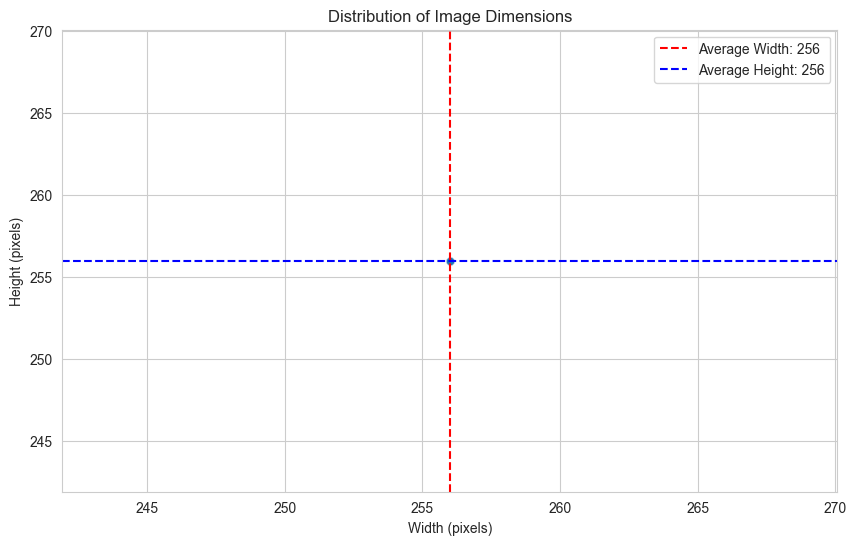

Average Width: 256 pixels 
Average Height: 256 pixels


In [7]:
# Initialize lists to store dimensions
dim1, dim2 = [], []

# Iterate over each label in your dataset and collect image dimensions
for label in labels:
    label_path = os.path.join(train_path, label)
    for image_filename in os.listdir(label_path):
        img_path = os.path.join(label_path, image_filename)
        img = imread(img_path)
        d1, d2 = img.shape[:2]  # Only need width and height
        dim1.append(d1)
        dim2.append(d2)

# Visualize the distribution of image dimensions
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dim2, y=dim1, alpha=0.5)
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.title("Distribution of Image Dimensions")

# Calculate and display the average dimensions
dim1_mean, dim2_mean = int(np.mean(dim1)), int(np.mean(dim2))
plt.axvline(x=dim2_mean, color='r', linestyle='--', label=f'Average Width: {dim2_mean}')
plt.axhline(y=dim1_mean, color='b', linestyle='--', label=f'Average Height: {dim1_mean}')
plt.legend()

plt.show()

print(f"Average Width: {dim2_mean} pixels \nAverage Height: {dim1_mean} pixels")

Save the average image dimensions

In [8]:

image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Save the image shape for future use

In [9]:
import joblib
joblib.dump(value=image_shape, filename=os.path.join(output_dir, "average_image_shape.pkl"))

['outputs/data_visualization/v1/average_image_shape.pkl']

## Visualize the different sample images

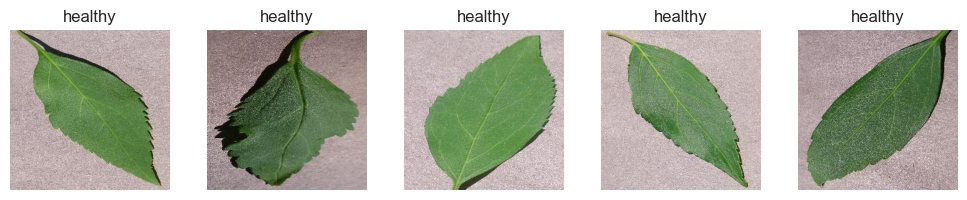

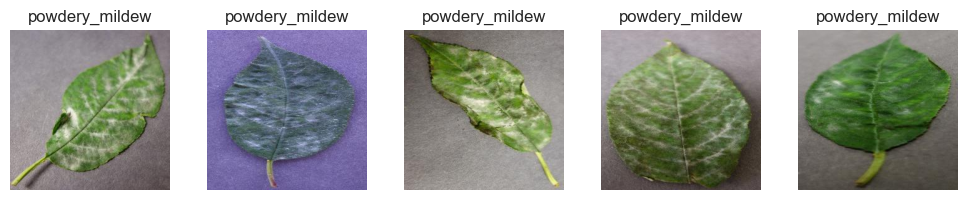

In [10]:
def display_samples_from_each_category(train_path, categories, samples_per_category=5, save=True):
    """
    Display and optionally save a grid of sample images from each specified category without showing image names.
    
    Parameters:
    - train_path (str): The path to the training dataset.
    - categories (list of str): A list of category names.
    - samples_per_category (int): The number of sample images to display per category.
    - save (bool): Whether to save the displayed images. Defaults to True.
    """
    
    for category in categories:
        fig, axes = plt.subplots(nrows=1, ncols=samples_per_category, figsize=(samples_per_category * 2, 2))
        sample_images = os.listdir(os.path.join(train_path, category))[:samples_per_category]
        
        for j, image_name in enumerate(sample_images):
            img_path = os.path.join(train_path, category, image_name)
            img = Image.open(img_path)
            ax = axes[j]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"{category}")
        
        plt.tight_layout()
        
        # Optionally save the grid image
        if save:
            save_path = os.path.join(generated_images_dir, f"{category}_samples_grid.png")
            plt.savefig(save_path)
        
        plt.show()

display_samples_from_each_category(train_path, categories)

---

## Average and variability of images  per label

### Function to load the average image and its variability for a given category

In [11]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img


def compute_average_and_variability_images(category_path, image_size, category_name, generated_images_dir):
    """
    Compute the average image and its variability for a given category and save them.
    
    Parameters:
    - category_path (str): The path to the category directory.
    - image_size (tuple): The target size to resize images.
    - category_name (str): The name of the category, used for saving the images.
    """
    image_list = []
    
    # Load each image, resize it if necessary, and append it to the list
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0  # Normalize the image
        image_list.append(img_array)
        
    # Stack images along a new dimension (shape: (num_images, height, width, channels))
    image_stack = np.stack(image_list, axis=0)
    
    # Compute the average and the standard deviation along the stack
    avg_image = np.mean(image_stack, axis=0)
    std_image = np.std(image_stack, axis=0)
    
    # Save the average and variability images
    imsave(os.path.join(generated_images_dir, f"{category_name}_average.png"), avg_image)
    imsave(os.path.join(generated_images_dir, f"{category_name}_variability.png"), std_image)
    
    return avg_image, std_image


Display the average image and its variability for each specified category

In [12]:
def display_average_and_variability_images(train_path, categories, generated_images_dir, image_size=(256, 256)):
    """
    Parameters:
    - train_path (str): The path to the training dataset.
    - categories (list of str): A list of category names.
    - generated_images_dir (str): The directory to save the generated images.
    - image_size (tuple): The target size to resize images (default: (256, 256)).
    """
    
    fig, axes = plt.subplots(nrows=len(categories), ncols=2, figsize=(10, 5 * len(categories)))

    for i, category in enumerate(categories):
        category_path = os.path.join(train_path, category)
        avg_image, var_image = compute_average_and_variability_images(category_path, image_size, category, generated_images_dir)
        
        # Display average image
        ax_avg = axes[i, 0]
        ax_avg.imshow(avg_image)
        ax_avg.set_title(f'Average Image - {category}')
        ax_avg.axis('off')
        
        # Display variability image
        ax_var = axes[i, 1]
        ax_var.imshow(var_image)
        ax_var.set_title(f'Variability Image - {category}')
        ax_var.axis('off')

    plt.tight_layout()
    plt.show()


Set the target image size

In [13]:
target_image_size = (256, 256)

Call the function to display the average and variability images

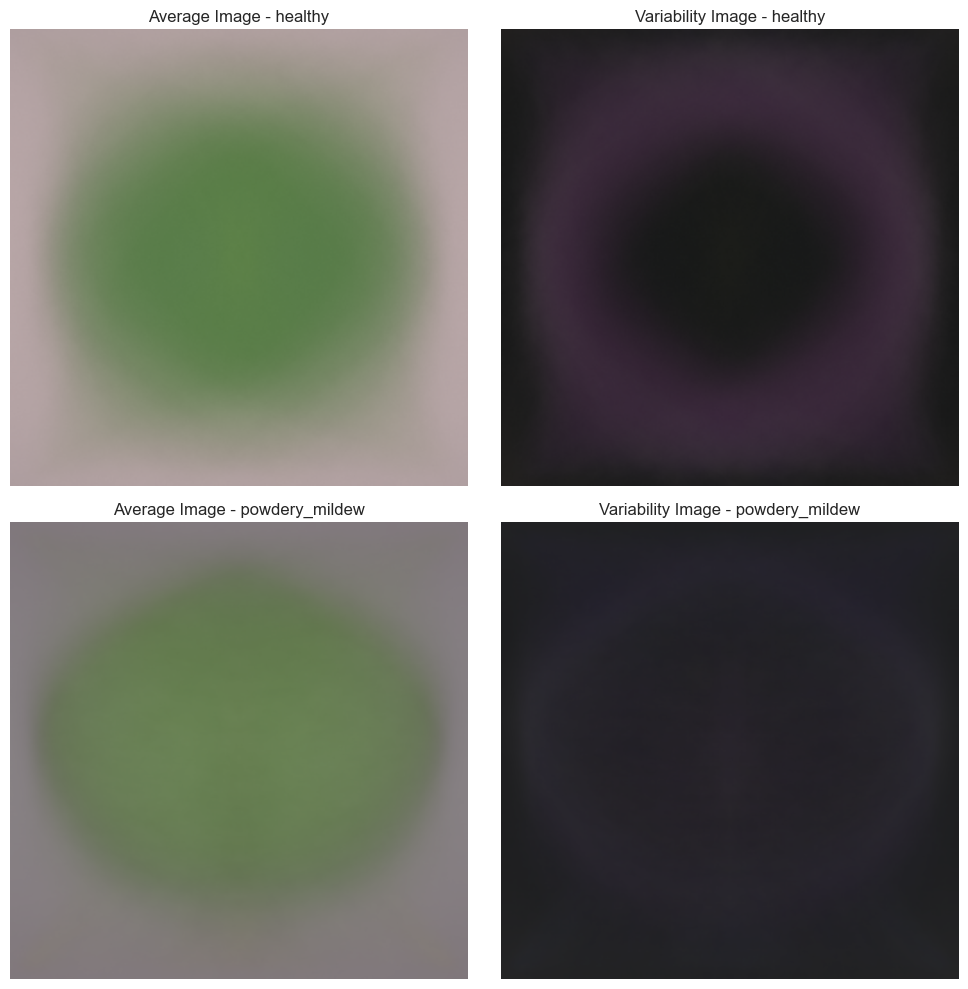

In [14]:
display_average_and_variability_images(train_path, categories, image_size=target_image_size, generated_images_dir=generated_images_dir)

---

## Difference between average healthy leaf and average mildew covered leaf images

Calculate and show difference between averages

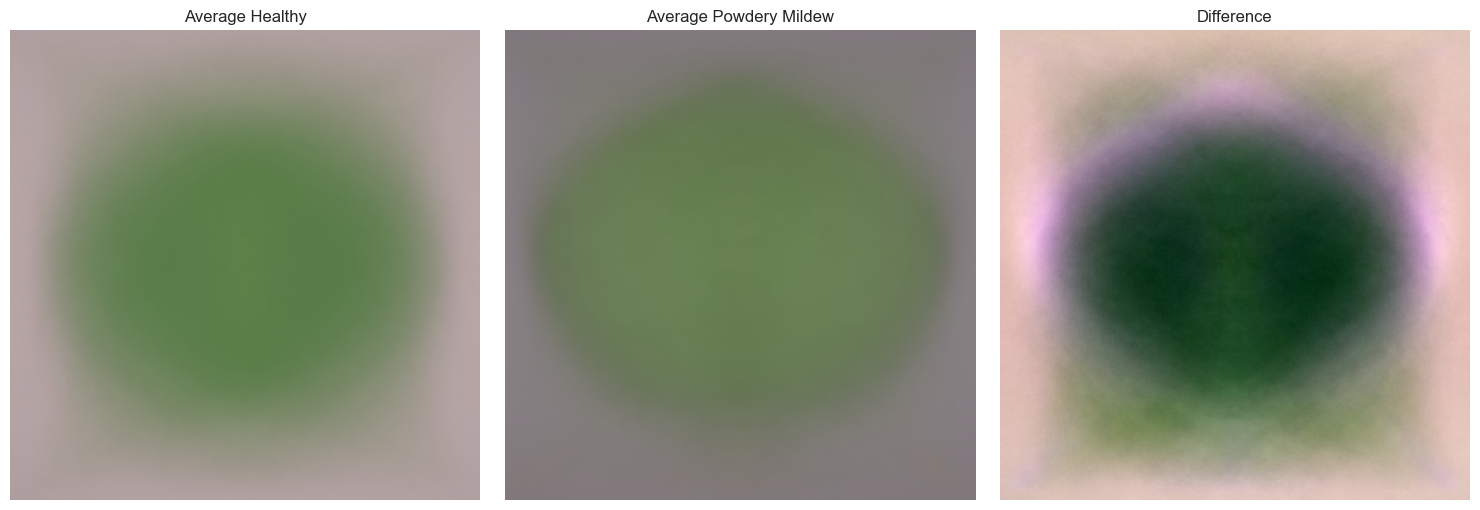

In [15]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) / (image_max - image_min)

def show_difference_between_averages(train_path, categories, generated_images_dir, image_size=(256, 256)):
    avg_images = {}
    # Compute average for each category
    for category in categories:
        category_path = os.path.join(train_path, category)
        # Assuming compute_average_and_variability_images now also saves the images
        avg_image, _ = compute_average_and_variability_images(category_path, image_size, category, generated_images_dir)
        avg_images[category] = avg_image
    difference_image = avg_images['healthy'] - avg_images['powdery_mildew']

    # Normalize the difference image
    normalized_difference_image = normalize_image(difference_image)

    # Save the normalized difference image
    difference_image_filename = "difference_between_averages.png"
    imsave(os.path.join(generated_images_dir, difference_image_filename), normalized_difference_image)

    # Plotting the difference
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(avg_images['healthy'])
    plt.title('Average Healthy')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(avg_images['powdery_mildew'])
    plt.title('Average Powdery Mildew')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(normalized_difference_image)
    plt.title('Difference')
    plt.axis('off')

    # Display the plot
    plt.tight_layout()
    plt.show()

show_difference_between_averages(train_path, categories, generated_images_dir, image_size=(256, 256))


## Image Montage

In [16]:
def create_image_montage(train_path, categories, generated_images_dir, samples_per_category=5, image_size=(256, 256)):
    for category in categories:
        fig, axes = plt.subplots(1, samples_per_category, figsize=(20, 5))
        sample_images = os.listdir(os.path.join(train_path, category))[:samples_per_category]
        for i, sample in enumerate(sample_images):
            img_path = os.path.join(train_path, category, sample)
            img = Image.open(img_path).resize(image_size)
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.tight_layout()
        montage_filename = f"{category}_montage.png"
        plt.savefig(os.path.join(generated_images_dir, montage_filename))
        plt.close(fig)


Create image montage

In [17]:
create_image_montage(train_path, categories, generated_images_dir,)

---